# Perturb-seq K562 co-expression

In [21]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools
from pybedtools import BedTool
import pickle as pkl
import gseapy as gp
from gseapy.plot import gseaplot

%matplotlib inline

In [3]:
pd.set_option('max_columns', None)

In [4]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [5]:
data_path = '/data_volume/memento/k562/'

### Read the guide labled K562 data

From perturbseq paper

In [6]:
adata = sc.read(data_path + 'h5ad/filtered-tf-perturbseq.h5ad')

In [7]:
guides = adata.obs.guides.drop_duplicates().tolist()
guides = [g for g in guides if ('INTER' not in g and 'nan' not in g)]
ko_genes = adata.obs.query('KO == 1')['KO_GENE'].drop_duplicates().tolist()

### Setup memento

In [8]:
adata.obs['q'] = 0.07

In [9]:
memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.07)

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:68: RankWarning: Polyfit may be poorly conditioned


### Do a 1D test to find highly variable genes

In [12]:
wt_subset = adata[adata.obs.WT].copy().copy()
memento.create_groups(wt_subset, label_columns=['leiden'])
memento.compute_1d_moments(wt_subset, min_perc_group=.9)
memento.ht_1d_moments(
    wt_subset, 
    formula_like='1',
    cov_column='Inter', 
    num_boot=10000, 
    verbose=1,
    num_cpus=70)

[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    4.2s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    6.8s
[Parallel(n_jobs=70)]: Done 660 tasks      | elapsed:   10.2s
[Parallel(n_jobs=70)]: Done 1110 tasks      | elapsed:   14.3s
[Parallel(n_jobs=70)]: Done 1660 tasks      | elapsed:   19.3s
[Parallel(n_jobs=70)]: Done 2310 tasks      | elapsed:   25.1s
[Parallel(n_jobs=70)]: Done 3060 tasks      | elapsed:   32.4s
[Parallel(n_jobs=70)]: Done 3910 tasks      | elapsed:   40.6s
[Parallel(n_jobs=70)]: Done 4860 tasks      | elapsed:   49.2s
[Parallel(n_jobs=70)]: Done 5910 tasks      | elapsed:   59.3s
[Parallel(n_jobs=70)]: Done 7060 tasks      | elapsed:  1.2min
[Parallel(n_jobs=70)]: Done 8310 tasks      | elapsed:  1.3min
[Parallel(n_jobs=70)]: Done 9135 out of 9135 | elapsed:  1.5min finished


In [17]:
df = memento.get_1d_ht_result(wt_subset).query('~gene.str.startswith("MT-")', engine='python')

In [18]:
df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])

In [131]:
import gseapy as gp
from gseapy.plot import gseaplot


In [26]:
pre_res = gp.prerank(
    rnk=df[['gene','dv_coef']].sort_values('dv_coef'), 
    gene_sets='GO_Biological_Process_2018',
    processes=4,
    permutation_num=100, # reduce number to speed up testing
    outdir=None, seed=6)

In [27]:
terms = pre_res.res2d.index


In [28]:
gsea_table = pre_res.res2d.sort_index().sort_values('fdr')


In [73]:
gsea_table.query('es > 0').head(20)

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Amyloid fiber formation Homo sapiens R-HSA-977225,0.799271,2.082007,0.000000,0.000000,68,29,LYZ;HIST2H2AC;HIST1H2AC;HIST1H2BJ;HIST1H2BK;HI...,LYZ;HIST2H2AC;HIST1H2AC;HIST1H2BJ;HIST1H2BK;HI...
Response to elevated platelet cytosolic Ca2+ Homo sapiens R-HSA-76005,0.702744,2.088577,0.000000,0.000000,110,49,TIMP1;FN1;HSPA5;IGF1;SCG3;SRGN;CLU;SEPP1;TMSB4...,TIMP1;FN1;HSPA5;IGF1;SCG3;SRGN;CLU;SEPP1;TMSB4...
DNA Damage/Telomere Stress Induced Senescence Homo sapiens R-HSA-2559586,0.781334,2.279978,0.000000,0.000000,59,40,HIST2H2AC;HIST1H1E;HIST1H1D;HIST1H1C;HIST1H2AC...,HIST2H2AC;HIST1H1E;HIST1H1D;HIST1H1C;HIST1H2AC...
HSF1-dependent transactivation Homo sapiens R-HSA-3371571,0.760495,1.996394,0.000000,0.002397,34,22,HSPA1A;HSPA8;HSP90AA1;MRPL18;DNAJB1;HSPH1;RPTO...,HSPA1A;HSPA8;HSP90AA1;MRPL18;DNAJB1;HSPH1;RPTO...
Class A/1 (Rhodopsin-like receptors) Homo sapiens R-HSA-373076,0.765897,1.996482,0.000000,0.002663,323,24,TAC3;ANXA1;NMU;NPW;GAL;CXCL3;KISS1R;TBXA2R;ADO...,TAC3;ANXA1;NMU;NPW;GAL;CXCL3;KISS1R;TBXA2R;ADO...
Immunoregulatory interactions between a Lymphoid and a non-Lymphoid cell Homo sapiens R-HSA-198933,0.783890,1.998468,0.016129,0.002996,157,19,TYROBP;CD3D;IFITM1;CLEC2B;B2M;CD33;HLA-E;ICAM2...,TYROBP;CD3D;IFITM1;CLEC2B;B2M;CD33;HLA-E;ICAM2
Condensation of Prophase Chromosomes Homo sapiens R-HSA-2299718,0.780495,2.059061,0.000000,0.003196,41,25,HIST2H2AC;HIST1H2AC;CCNB1;CDK1;PLK1;HIST1H2BJ;...,HIST2H2AC;HIST1H2AC;CCNB1;CDK1;PLK1;HIST1H2BJ;...
Attenuation phase Homo sapiens R-HSA-3371568,0.797001,2.004354,0.000000,0.003424,26,17,HSPA1A;HSPA8;HSP90AA1;MRPL18;DNAJB1;HSPH1;SERP...,HSPA1A;HSPA8;HSP90AA1;MRPL18;DNAJB1;HSPH1
RMTs methylate histone arginines Homo sapiens R-HSA-3214858,0.712369,2.011999,0.000000,0.003995,45,32,HIST1H2AA;HIST2H2AC;HIST1H2AC;CCND1;HIST1H2AH;...,HIST1H2AA;HIST2H2AC;HIST1H2AC;CCND1;HIST1H2AH


In [39]:
hvg = df.query('dv_fdr < 0.05 & dv_coef > 0.5').gene.tolist()
lvg = df.query('dv_fdr < 0.05 & dv_coef < -0.5').gene.tolist()

Text(0, 0.5, 'Variability')

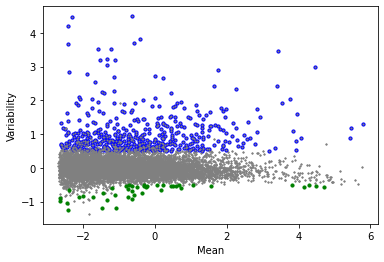

In [69]:
plt.scatter(df['de_coef'], df['dv_coef'], s=1, color='grey')
plt.scatter(df.query('gene in @hvg')['de_coef'], df.query('gene in @hvg')['dv_coef'], s=10, color='b')
plt.scatter(df['de_coef'], df['dv_coef'], s=1, color='grey')
plt.scatter(df.query('gene in @lvg')['de_coef'], df.query('gene in @lvg')['dv_coef'], s=10, color='g')
plt.xlabel('Mean'); plt.ylabel('Variability')

### Memento

In [118]:
results = {}
moments = {}

In [119]:
for g in ko_genes:
    
    print(g)
    
    subset = adata[adata.obs.WT | (adata.obs.KO_GENE == g), hvg+lvg].copy().copy()
    
    memento.create_groups(subset, label_columns=['KO', 'leiden'])
    memento.compute_1d_moments(subset, min_perc_group=.9)
    
    memento.ht_1d_moments(
        subset, 
        formula_like='1 + KO',
        cov_column='KO', 
        num_boot=10000, 
        verbose=1,
        num_cpus=70)
    guide_df = memento.get_1d_ht_result(subset)
    
    results[g] = memento.get_1d_ht_result(subset)
    moments[g] = memento.get_1d_moments(subset, groupby='KO')

ELK1


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    4.4s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    7.6s
[Parallel(n_jobs=70)]: Done 523 out of 523 | elapsed:   13.1s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


ELF1


[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    1.1s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    4.2s
[Parallel(n_jobs=70)]: Done 521 out of 521 | elapsed:   10.7s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


IRF1


[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    0.9s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    3.3s
[Parallel(n_jobs=70)]: Done 513 out of 513 | elapsed:    7.6s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


ETS1


[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    1.0s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    3.8s
[Parallel(n_jobs=70)]: Done 520 out of 520 | elapsed:    8.8s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


EGR1


[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    1.0s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    3.6s
[Parallel(n_jobs=70)]: Done 525 out of 525 | elapsed:    8.7s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


YY1


[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    1.0s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    4.1s
[Parallel(n_jobs=70)]: Done 508 out of 508 | elapsed:    9.3s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


GABPA


[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    1.0s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    3.9s
[Parallel(n_jobs=70)]: Done 514 out of 514 | elapsed:    8.9s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


E2F4


[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    1.0s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    3.7s
[Parallel(n_jobs=70)]: Done 520 out of 520 | elapsed:    8.6s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


NR2C2


[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    1.0s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    3.7s
[Parallel(n_jobs=70)]: Done 518 out of 518 | elapsed:    8.7s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


CREB1


[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    1.0s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    3.5s
[Parallel(n_jobs=70)]: Done 519 out of 519 | elapsed:    8.8s finished


In [120]:
for g in ko_genes:
    results[g]['de_fdr'] = memento.util._fdrcorrect(results[g]['de_pval'])
    results[g]['dv_fdr'] = memento.util._fdrcorrect(results[g]['dv_pval'])
    
    results[g]['class'] = results[g].gene.apply(lambda x: 'hvg' if x in hvg else 'lvg')
    print(g)
    print(results[g].query('dv_fdr < 0.1')[['gene', 'dv_coef', 'class', 'dv_fdr']])

ELK1
    gene   dv_coef class    dv_fdr
74   FN1 -1.839776   hvg  0.042976
353  LYZ -1.559115   hvg  0.098766
ELF1
Empty DataFrame
Columns: [gene, dv_coef, class, dv_fdr]
Index: []
IRF1
      gene   dv_coef class    dv_fdr
207  TIMP1 -2.304302   hvg  0.019604
ETS1
      gene   dv_coef class    dv_fdr
208   SAT1 -1.693064   hvg  0.081772
319  NEAT1 -0.687979   hvg  0.062826
EGR1
Empty DataFrame
Columns: [gene, dv_coef, class, dv_fdr]
Index: []
YY1
          gene   dv_coef class    dv_fdr
0        SMIM1  0.532605   hvg  0.015871
2          ID3 -0.509430   hvg  0.073370
35       PTPRC  0.301594   hvg  0.093124
41        G0S2  0.262431   hvg  0.015871
44      FAM89A  0.320781   hvg  0.028205
71         FN1 -1.647851   hvg  0.015867
99         NMU  0.267973   hvg  0.041274
108       GYPA  0.421620   hvg  0.012617
116     HMGCS1  0.588160   hvg  0.073370
118      MEF2C  0.276373   hvg  0.085826
149  HIST1H2BK  0.147918   hvg  0.073370
189  LINC00998  0.344715   hvg  0.012153
280      DDIT4  

In [123]:
dv_genes = results['YY1'].query('dv_fdr < 0.1').gene.tolist()
moment_df = moments['YY1']

In [136]:
g

'ID3'

In [140]:
moment_df[0].query('gene =="{}"'.format(g))['KO_0'].iloc[0]

-0.39352927

Text(0.5, 1.0, 'Effect of YY1 KO on highly/lowly variable genes')

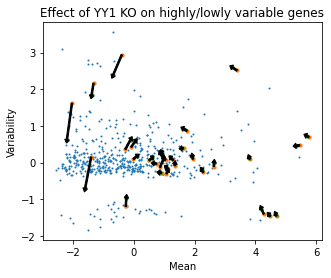

In [144]:
plt.figure(figsize=(5, 4))
plt.scatter(moment_df[0]['KO_0'], moment_df[1]['KO_0'], s=1)
plt.scatter(moment_df[0].query('gene in @dv_genes')['KO_0'], moment_df[1].query('gene in @dv_genes')['KO_0'], s=10)
plt.scatter(moment_df[0].query('gene in @dv_genes')['KO_1'], moment_df[1].query('gene in @dv_genes')['KO_1'], s=10)

for g in dv_genes:
    
    x,y = moment_df[0].query('gene =="{}"'.format(g))['KO_0'].iloc[0], moment_df[1].query('gene =="{}"'.format(g))['KO_0'].iloc[0]
    dx = moment_df[0].query('gene =="{}"'.format(g))['KO_1'].iloc[0] - x
    dy = moment_df[1].query('gene =="{}"'.format(g))['KO_1'].iloc[0] - y
    plt.arrow(x,y, dx, dy, width=0.05, head_length=0.1, color='black')
plt.xlabel('Mean'); plt.ylabel('Variability'); plt.title('Effect of YY1 KO on highly/lowly variable genes')

In [117]:
moment_df[1].merge(results['YY1'], on='gene').query('dv_fdr < 0.1')

,gene,KO_0,KO_1,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr,class
0,SMIM1,-0.177695,0.357348,-0.235923,0.027202,0.000025,0.535043,0.105522,0.000168,0.001783,0.021019,hvg
2,ID3,3.133432,2.441684,-0.024830,0.106311,0.820418,-0.691749,0.198047,0.000609,0.889684,0.032625,hvg
41,G0S2,0.687833,0.949137,-0.313494,0.029049,0.000002,0.261304,0.058181,0.000294,0.001276,0.024993,hvg
44,FAM89A,-0.214823,0.075370,-0.118510,0.027122,0.000096,0.290193,0.089960,0.001200,0.002345,0.035587,hvg
73,FN1,1.978782,0.433984,-0.481454,0.122483,0.000425,-1.544798,0.357327,0.000335,0.003995,0.024993,hvg
101,NMU,0.190416,0.468572,-0.169234,0.024094,0.000493,0.278156,0.083103,0.001456,0.004238,0.035587,hvg
110,GYPA,-0.137167,0.294541,-0.192191,0.027254,0.000084,0.431708,0.096428,0.000188,0.002345,0.021019,hvg
118,HMGCS1,0.083599,0.666764,0.313811,0.042515,0.000507,0.583166,0.202375,0.004100,0.004238,0.071333,hvg
120,MEF2C,-0.079590,0.238189,-0.116019,0.030437,0.001347,0.317779,0.092005,0.001267,0.007174,0.035587,hvg
144,HIST1H1E,0.912989,0.710116,-0.042872,0.035914,0.234577,-0.202874,0.071788,0.004600,0.391627,0.077450,hvg


In [106]:
moment_df[1].query('gene in @dv_genes').head(50)

,gene,KO_0,KO_1
0,SMIM1,0.126938,0.154422
2,ID3,2.920587,2.718396
41,G0S2,0.938037,0.963738
44,FAM89A,-0.012711,-0.024366
71,FN1,1.565450,1.368743
99,NMU,0.443965,0.443022
108,GYPA,0.132742,0.141289
116,HMGCS1,0.317073,0.440650
118,MEF2C,0.088346,0.096627
148,HIST1H2BK,0.174818,0.181724


In [45]:
guide_df = memento.get_1d_ht_result(subset)

In [49]:
guide_df['de_fdr'] = memento.util._fdrcorrect(guide_df['de_pval'])
guide_df['dv_fdr'] = memento.util._fdrcorrect(guide_df['dv_pval'])

In [50]:
guide_df.query('dv_fdr < 0.1')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
74,FN1,-0.462806,0.107527,0.000226,-1.839776,0.289305,0.000088,0.068673,0.037803
353,LYZ,-0.390178,0.130690,0.002700,-1.559115,0.330854,0.000145,0.235326,0.037803


In [ ]:
for g, result in result_1d_dict.items():
    
    result.to_csv(data_path + '/result_1d/{}.csv'.format(g), index=False)

### Get 1D results

In [ ]:
result_1d_dict = {g:pd.read_csv(data_path + '/result_1d/{}.csv'.format(g)) for g in guides if ('INTER' not in g and 'nan' not in g)}

In [ ]:
g = 'p_sgGABPA_9'
df = result_1d_dict[g]
df.query('de_fdr < 0.1 | dv_fdr < 0.1')

In [ ]:
for g in guides:
    
    df = result_1d_dict[g]
    df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])
    df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
    
    print(g, df.query('de_fdr < 0.15').shape[0], df.query('dv_fdr < 0.15').shape[0])

### DV shift plots

In [ ]:
for g in guides:
    df = result_1d_dict[g]
    plt.figure()
    sns.kdeplot(df['dv_coef']);
    plt.plot([0, 0], [0, 2])
    plt.title(g)
    plt.xlim(-2, 2)
    

### within WT

In [ ]:
adata[adata.obs.WT].obs.guides.value_counts()

In [ ]:
subset = adata[(adata.obs.guides=='p_INTERGENIC393453') | (adata.obs.guides=='p_INTERGENIC216151') ].copy().copy()

memento.create_groups(subset, label_columns=['guides'])
memento.compute_1d_moments(subset, min_perc_group=.9)

memento.ht_1d_moments(
    subset, 
    formula_like='1 + guides',
    cov_column='guides', 
    num_boot=10000, 
    verbose=1,
    num_cpus=14)

wt_result = memento.get_1d_ht_result(subset)

In [ ]:
sns.kdeplot(wt_result.dv_coef)
plt.title('WT')
plt.plot([0, 0], [0, 2])

### Get the change in magnitude for each guide

In [ ]:
coef_mag = []
for g, df in result_1d_dict.items():
    coef_mag.append((g, df['de_coef'].abs().median()))
coef_mag = pd.DataFrame(coef_mag, columns=['guide', 'de_mag'])
coef_mag['gene'] = coef_mag['guide'].str.split('_').str[1].str[2:]

### Get WT variability of each TF

In [ ]:
wt_adata = adata[adata.obs['WT']].copy().copy()

In [ ]:
tfs = adata.obs.query('KO==1').KO_GENE.drop_duplicates().tolist()

In [ ]:
memento.create_groups(wt_adata, label_columns=['KO'])
memento.compute_1d_moments(wt_adata, min_perc_group=.9,)

In [ ]:
tf_moments = memento.get_1d_moments(wt_adata, groupby='KO')

### Compare WT variability to De mag

In [ ]:
merged = coef_mag.merge(tf_moments[1], on='gene')

In [ ]:
stats.spearmanr(merged['de_mag'], merged['KO_0'])

In [ ]:
plt.scatter(merged['de_mag'], merged['KO_0'])

### Number of TF binding sites within 5k(?) KB


In [ ]:
enc = encode.Encode('/home/ssm-user/Github/misc-seq/miscseq/GRCh38Genes.bed')

In [ ]:
encode_links = {
    'ELK1':'https://www.encodeproject.org/files/ENCFF119SCQ/@@download/ENCFF119SCQ.bed.gz',
    'ELF1':'https://www.encodeproject.org/files/ENCFF133TSU/@@download/ENCFF133TSU.bed.gz',
    'IRF1':'https://www.encodeproject.org/files/ENCFF203LRV/@@download/ENCFF203LRV.bed.gz',
    'ETS1':'https://www.encodeproject.org/files/ENCFF461PRP/@@download/ENCFF461PRP.bed.gz',
    'EGR1':'https://www.encodeproject.org/files/ENCFF375RDB/@@download/ENCFF375RDB.bed.gz',
    'YY1':'https://www.encodeproject.org/files/ENCFF635XCI/@@download/ENCFF635XCI.bed.gz',
    'GABPA':'https://www.encodeproject.org/files/ENCFF173GUD/@@download/ENCFF173GUD.bed.gz',
    'E2F4':'https://www.encodeproject.org/files/ENCFF225TLP/@@download/ENCFF225TLP.bed.gz',
    'NR2C2':'https://www.encodeproject.org/files/ENCFF263VIC/@@download/ENCFF263VIC.bed.gz',
    'CREB1':'https://www.encodeproject.org/files/ENCFF193LLN/@@download/ENCFF193LLN.bed.gz'
}

In [ ]:
bed_objs = {tf:enc.get_encode_peaks(link) for tf,link in encode_links.items()}

In [ ]:
target_genes = {tf:enc.get_peak_genes_bed(bed_obj, 0).query('distance==0').gene.tolist() for tf, bed_obj in bed_objs.items()}

In [ ]:
x = wt_adata[:, 'EGR1'].X.todense().A1

In [ ]:
np.bincount(x.astype(int))

In [ ]:
x.mean()

In [ ]:
plt.hist(x, bins=20)

In [ ]:
target_numbers = []
for tf in encode_links.keys():
    target_numbers.append((tf, len(target_genes[tf])))
target_numbers = pd.DataFrame(target_numbers, columns=['gene', 'num_targets'])

In [ ]:
merged = target_numbers.merge(tf_moments[1], on='gene')

In [ ]:
stats.pearsonr(merged.query('gene != "EGR1"')['num_targets'], merged.query('gene != "EGR1"')['KO_0'])

In [ ]:
plt.scatter(merged['num_targets'], merged['KO_0'])

### Try with all ENCODE

In [ ]:
merged

In [ ]:
all_encode = pd.read_csv('gene_attribute_matrix.txt', sep='\t', index_col=0, low_memory=False).iloc[2:, 2:].astype(float)

In [ ]:
target_counts = pd.DataFrame(all_encode.sum(axis=0), columns=['num_targets']).reset_index().rename(columns={'index':'gene'})

In [ ]:
x = target_counts.query('gene in @tfs').sort_values('gene')['num_targets']
y = merged.sort_values('gene')['num_targets']

In [ ]:
merged2 = target_counts.merge(tf_moments[1], on='gene')

In [ ]:
plt.scatter(merged2['num_targets'], merged2['KO_0'])

In [ ]:
merged2

### Get gene list

In [ ]:
wt_adata = adata[adata.obs['WT']].copy().copy()

In [ ]:
memento.create_groups(wt_adata, label_columns=['KO'])
memento.compute_1d_moments(wt_adata, min_perc_group=.9)

In [ ]:
plt.hist(np.log(wt_adata.uns['memento']['1d_moments']['sg^0'][0]))

In [ ]:
wt_high_genes = wt_adata.var.index[np.log(wt_adata.uns['memento']['1d_moments']['sg^0'][0]) > -1].tolist()

### Create labels for X genes

In [ ]:
chr_locations = pd.read_csv('chr_locations.bed', sep='\t').rename(columns={'#chrom':'chr'}).drop_duplicates('geneName')

In [ ]:
chr_locations.index=chr_locations.geneName

In [ ]:
adata.var = adata.var.join(chr_locations, how='left')

### Filter X-chromosomal genes

In [ ]:
adata_X = adata[:, (adata.var.chr=='chrX') | adata.var.chr.isin(['chr1', 'chr2', 'chr3'])].copy()

In [ ]:
adata_X

### Escape genes

In [ ]:
par_genes = """PLCXD1 GTPBP6 PPP2R3B SHOX CRLF2 CSF2RA IL3RA SLC25A6 ASMTL P2RY8 ASMT DHRSXY ZBED1 CD99 XG IL9R SPRY3 VAMP7""".split()

In [ ]:
escape_genes = """EIF1AX
USP9X
EIF2S3
CTPS2
TRAPPC2
HDHD1
ZFX
DDX3X
RAB9A
AP1S2
GEMIN8
RPS4X
SMC1A
ZRSR2
STS
FUNDC1
PNPLA4
UBA1
ARSD
NLGN4X
GPM6B
MED14
CD99
RBBP7
SYAP1
PRKX
OFD1
CXorf38
TXLNG
KDM5C
GYG2
TBL1X
CA5B
XIST
RENBP
HCFC1
USP11
PLCXD1
SLC25A6
ASMTL
DHRSX
XG
TMEM27
ARHGAP4
GAB3
PIR
TMEM187
DOCK11
EFHC2
RIBC1
NAP1L3
CA5BP1
MXRA5
KAL1
PCDH11X
KDM6A
PLS3
CITED1
L1CAM
ALG13
BCOR""".split()

### Run 1d memento

In [ ]:
adata_X.obs['is_female'] = (adata_X.obs['Sex'] == 'Female').astype(int)

In [ ]:
adata_X.obs.is_female.value_counts()

In [ ]:
memento.create_groups(adata_X, label_columns=['is_female', 'ind_cov'])
memento.compute_1d_moments(adata_X, min_perc_group=.9)

In [ ]:
memento.ht_1d_moments(
    adata_X, 
    formula_like='1 + is_female',
    cov_column='is_female', 
    num_boot=20000, 
    verbose=1,
    num_cpus=13)

In [ ]:
result_1d = memento.get_1d_ht_result(adata_X)

In [ ]:
result_1d['dv_fdr'] = memento.util._fdrcorrect(result_1d['dv_pval'])

In [ ]:
sns.distplot(result_1d.dv_coef)

In [ ]:
x_chr_genes = adata.var.index[adata.var.chr=='chrX'].tolist()

In [ ]:
result_1d['escape'] = result_1d['gene'].isin(escape_genes)
result_1d['par'] = result_1d['gene'].isin(par_genes)
result_1d['x_chr'] = result_1d['gene'].isin(x_chr_genes)

In [ ]:
sns.distplot(result_1d.query('~x_chr').dv_coef)
sns.distplot(result_1d.query('x_chr').dv_coef)


In [ ]:
sns.boxplot(x='x_chr', y='dv_coef', data=result_1d)

In [ ]:
dv_genes = result_1d.query('dv_fdr < 0.1').gene.tolist()

In [ ]:
result_1d['dv'] = result_1d.gene.isin(dv_genes)

In [ ]:
result_1d.query('~dv & ~x_chr & dv_coef > 0').shape

In [ ]:
a = [[193, 14],
 [23,5]]

In [ ]:
stats.chi2_contingency(a)

In [ ]:
result_1d.query('dv_fdr < 0.1').x_chr.mean()

In [ ]:
result_1d.x_chr.mean()

### Run memento for each subset, comparing to control

In [ ]:
cts = [['ciliated'], ['bc','basal']]
# tps = ['3', '6', '9', '24', '48']
tps = ['3', '6', '9', '24', '48']

stims = ['alpha', 'beta', 'gamma', 'lambda']

In [ ]:
import os
done_files = os.listdir('/data_volume/ifn_hbec/binary_test_deep/')

In [ ]:
for ct in cts:
    for tp in tps:
        for stim in stims:
            
            fname = '{}_{}_{}_20200320.h5ad'.format('-'.join(ct), stim, tp)
            
            if fname in done_files:
                print('Skipping', fname)
                continue

            print('starting', ct, tp, stim)

            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin(['0',tp]), :].copy()
            time_converter={0:0, int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)

            memento.ht_1d_moments(
                adata_stim, 
                formula_like='1 + time_step',
                cov_column='time_step', 
                num_boot=10000, 
                verbose=1,
                num_cpus=13)

            del adata_stim.uns['memento']['mv_regressor']

            adata_stim.write('/data_volume/ifn_hbec/binary_test_deep/{}_{}_{}_20200320.h5ad'.format(
                '-'.join(ct), stim, tp))